In [24]:
import rmgpy.species
import rmgpy.kinetics
import rmgpy.thermo
import rmgpy.data.rmg

import copy

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:

def plot_thermos(thermos, labels=None):
    if type(thermos) != list:
        thermos = [thermos]
    if labels is None:
        labels = ['' for t in thermos]
    linestyles = ['solid', 'dashed', 'dotted']
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 1500, 1001)
    for m, thermo in enumerate(thermos):
        if 'cantera' in str(type(thermo)).lower() and hasattr(thermo, 'thermo'):
            thermo = thermo.thermo
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        if 'rmgpy' in str(type(thermo)).lower():
            for i in range(0, len(T)):
                H[i] = thermo.get_enthalpy(T[i]) / 1000.0
                S[i] = thermo.get_entropy(T[i]) / 1000.0
                Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        else:  # cantera
            for i in range(0, len(T)):
                H[i] = thermo.h(T[i]) / 1e6  # J/kmol
                S[i] = thermo.s(T[i]) / 1e6
                Cp[i] = thermo.cp(T[i]) / 1e6  # J/mol K
        ax[0].plot(T, H, linestyle=linestyles[m % len(linestyles)])
        ax[1].plot(T, S, linestyle=linestyles[m % len(linestyles)])
        ax[2].plot(T, Cp, linestyle=linestyles[m % len(linestyles)])
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    ax[2].yaxis.get_major_formatter().set_useOffset(False)
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [4]:
database = rmgpy.data.rmg.RMGDatabase()

thermo_libraries = [
    'Klippenstein_Glarborg2016',
    'BurkeH2O2',
    'thermo_DFT_CCSDTF12_BAC', 
    'DFT_QCI_thermo',
    'primaryThermoLibrary',
    'CurranPentane'
]

database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libraries,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],
    kinetics_families = ['H_Abstraction'],
    kinetics_depositories = ['training'],
    depository = False,
)
# !!!!!!!!!!!!!!!!!!!!!!!! Keep this for kinetics families
for family in database.kinetics.families:
    if not database.kinetics.families[family].auto_generated:
        database.kinetics.families[family].add_rules_from_training(thermo_database=database.thermo)
        database.kinetics.families[family].fill_rules_by_averaging_up(verbose=True)



# Example calculate thermo for butane using group additivity and libraries

In [5]:
CCCC = rmgpy.species.Species(smiles='CCCC')
display(CCCC)

In [7]:
thermo_data, thermo_library, thermo_entry = database.thermo.get_thermo_data_from_libraries(CCCC)
CCCC.thermo = thermo_data

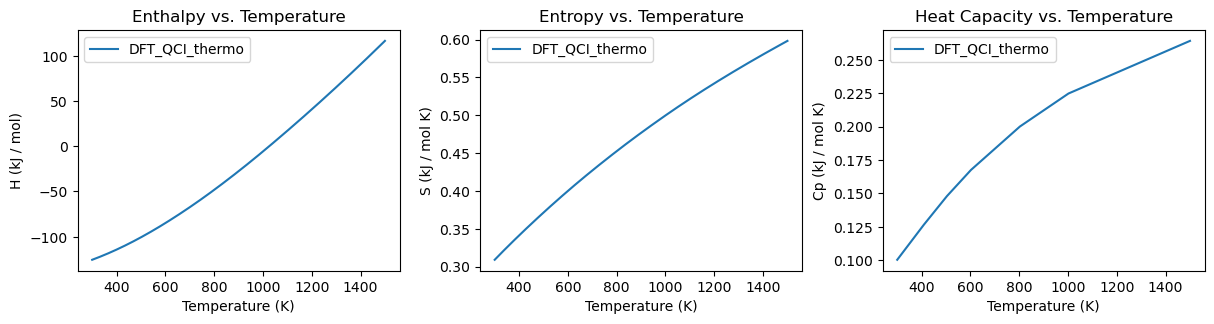

In [30]:
plot_thermos([CCCC], [thermo_library.name])

In [32]:
group_thermo = database.thermo.get_thermo_data_from_groups(CCCC)

# Where thermo groups are stored

In [21]:
CH2 = database.thermo.groups['group'].entries['Cs-CsCsHH']
CH3 = database.thermo.groups['group'].entries['Cs-CsHHH']

In [42]:
manual_data = copy.deepcopy(CH2.data)
manual_data = rmgpy.data.thermo.add_thermo_data(manual_data, CH2.data)
manual_data = rmgpy.data.thermo.add_thermo_data(manual_data, CH3.data)
manual_data = rmgpy.data.thermo.add_thermo_data(manual_data, CH3.data)
rmgpy.data.thermo.find_cp0_and_cpinf(CCCC, manual_data)

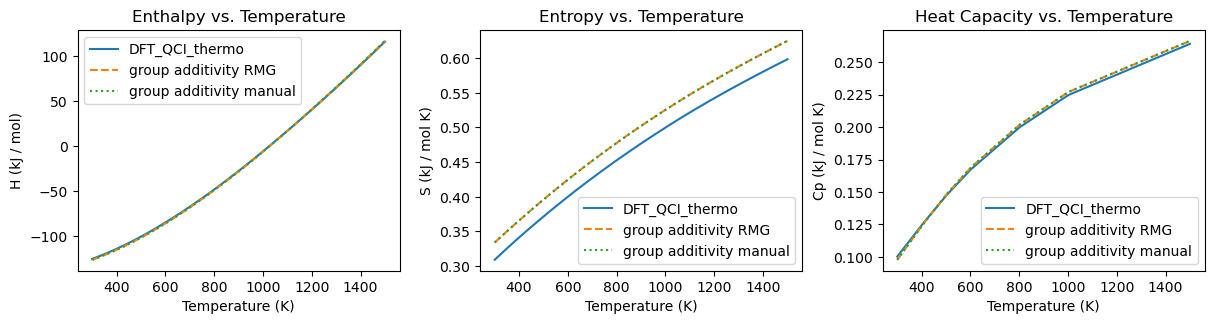

In [43]:
plot_thermos([CCCC, group_thermo, manual_data], [thermo_library.name, 'group additivity RMG', 'group additivity manual'])

In [37]:
group_thermo

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.8219,123.763,147.695,168.532,201.585,226.856,266.353],'J/(mol*K)'), H298=(-126.608,'kJ/mol'), S298=(333.297,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(Cs-CsHHH) + group(Cs-CsHHH)""")

In [35]:
manual_data

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([23.38,29.58,35.3,40.28,48.18,54.22,63.66],'cal/(mol*K)','+|-',[0.04,0.04,0.04,0.04,0.04,0.04,0.04]), H298=(-30.26,'kcal/mol','+|-',0.05), S298=(79.66,'cal/(mol*K)','+|-',0.13), comment="""group(Cs-CsCsHH)""")

In [45]:
group_thermo.is_similar_to(manual_data.to_nasa(300, 2000, 1000))

True